In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import celerite as ce
import emcee as mc
import QPP_Funcs as qpp
import corner
from celerite.modeling import Model
from scipy.optimize import minimize, curve_fit
import h5py

i=0
plots = []
corners = []
datadir = "/Users/chris/Documents/QPP/SolarFlareGPs/data/daniela_goes_data/"

#for burstid in range(1520110128,1520170715):
while (i<1):
    burstid = 1520111001 #np.random.randint(1520110128,1520170715)
    try:
        time, flux = qpp.load_data(datadir,burstid)
    except(IOError):
        pass
    else:
        time, flux = qpp.load_data(datadir,burstid)
        i+=1
        tt,ft = qpp.trim_data(time,flux)
        ft = ft*1e10  #cheating conversions!!!
        ft_err = np.sqrt(ft)
        print("Lightcurve " + str(i) + ", burstid: " + str(burstid))


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Lightcurve 1, burstid: 1520111001


Initializing...
Initial log-parameters:[ 0.          0.          0.          0.          0.         11.8767767
  6.70781152  7.4009587 ]


QPP_Funcs.py:22: RuntimeWarning: divide by zero encountered in divide
  return A*lam*np.exp((-tau1/t)-(t/tau2))


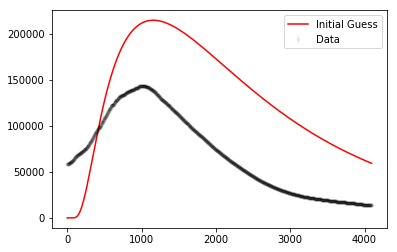

In [2]:
#initialization block
print("Initializing...")

A_guess, t1_guess, t2_guess = qpp.initguess(tt,ft)
model = qpp.CTSModel_prior(log_A = np.log(A_guess), log_tau1 = np.log(t1_guess), log_tau2 = np.log(t2_guess))
kernel1 = qpp.SHOTerm_Prior(log_S0 = 0, log_Q = 0, log_omega0 = 0) #write guesser for kernel parameters
kernel2 = qpp.RealTerm_Prior(log_a=0., log_c=0.) #write guesser for kernel parameters
kernel = kernel2 + kernel1
gp = ce.GP(kernel, mean=model, fit_mean=True)
gp.compute(tt, ft_err)
figinit = qpp.plot_gp(tt,ft, ft_err, gp, model, predict=True, label="Initial Guess")
initparams = gp.get_parameter_vector()
print("Initial log-parameters:" + str(initparams))
plt.show()

Optimizing...
Initial log-likelihood: -126735484.145
Final log-likelihood: -3069619.95946
Optimized log-parameters: [ 5.74572693e-05 -3.08506676e-05  4.43742560e-05  4.04400460e-07
  4.99217899e-06  1.13792759e+01  6.06470314e+00  7.05800440e+00]


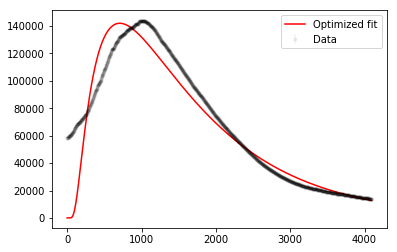

In [3]:
print("Optimizing...")

#optimization
soln = qpp.optimize_gp(gp, ft)
gp.set_parameter_vector(soln.x)
figopt = qpp.plot_gp(tt, ft, ft_err, gp, model, predict=True, label = "Optimized fit")
plt.show()


In [24]:

#sampling
sampler = qpp.sample_gp(initparams, ft, gp, burnin=1500, nwalkers=100, nsteps = 5000)
chain = sampler.chain

Burning in...


QPP_Funcs.py:22: RuntimeWarning: divide by zero encountered in divide
  return A*lam*np.exp((-tau1/t)-(t/tau2))
QPP_Funcs.py:81: RuntimeWarning: divide by zero encountered in log
  return np.log(prob_a*prob_c * np.e)
QPP_Funcs.py:21: RuntimeWarning: overflow encountered in exp
  lam = np.exp(np.sqrt(2*np.exp(tau1/tau2)))
QPP_Funcs.py:22: RuntimeWarning: invalid value encountered in multiply
  return A*lam*np.exp((-tau1/t)-(t/tau2))
QPP_Funcs.py:48: RuntimeWarning: divide by zero encountered in log
  return np.log(probA * probtau1 * probtau2 * np.e)
QPP_Funcs.py:66: RuntimeWarning: divide by zero encountered in log
  return np.log(prob_S0*prob_Q*prob_omega0 * np.e)
QPP_Funcs.py:22: RuntimeWarning: overflow encountered in double_scalars
  return A*lam*np.exp((-tau1/t)-(t/tau2))
QPP_Funcs.py:21: RuntimeWarning: overflow encountered in double_scalars
  lam = np.exp(np.sqrt(2*np.exp(tau1/tau2)))


Sampling...
Done!


Plotting time series...
Plotting posterior predictions...
Plotting corner plot...
Max logparams:
[-10.12960984  -5.04047431   4.98283988  10.84643827   2.6247738
  10.609056     6.79301973   6.78358305]
Max params:
[3.98810278e-05 6.47067848e-03 1.45888099e+02 5.13509272e+04
 1.38014519e+01 4.04999491e+04 8.91601902e+02 8.83227714e+02]


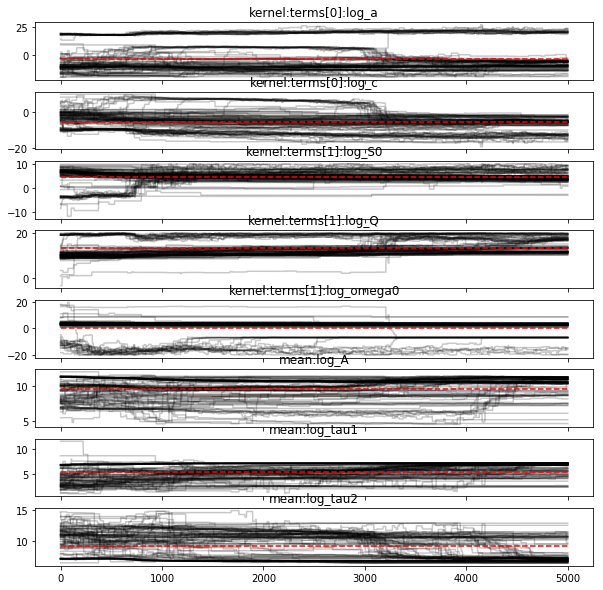

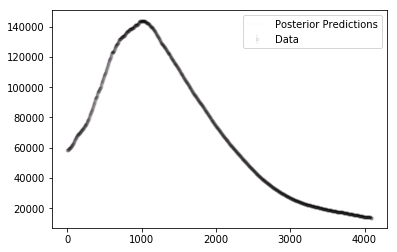

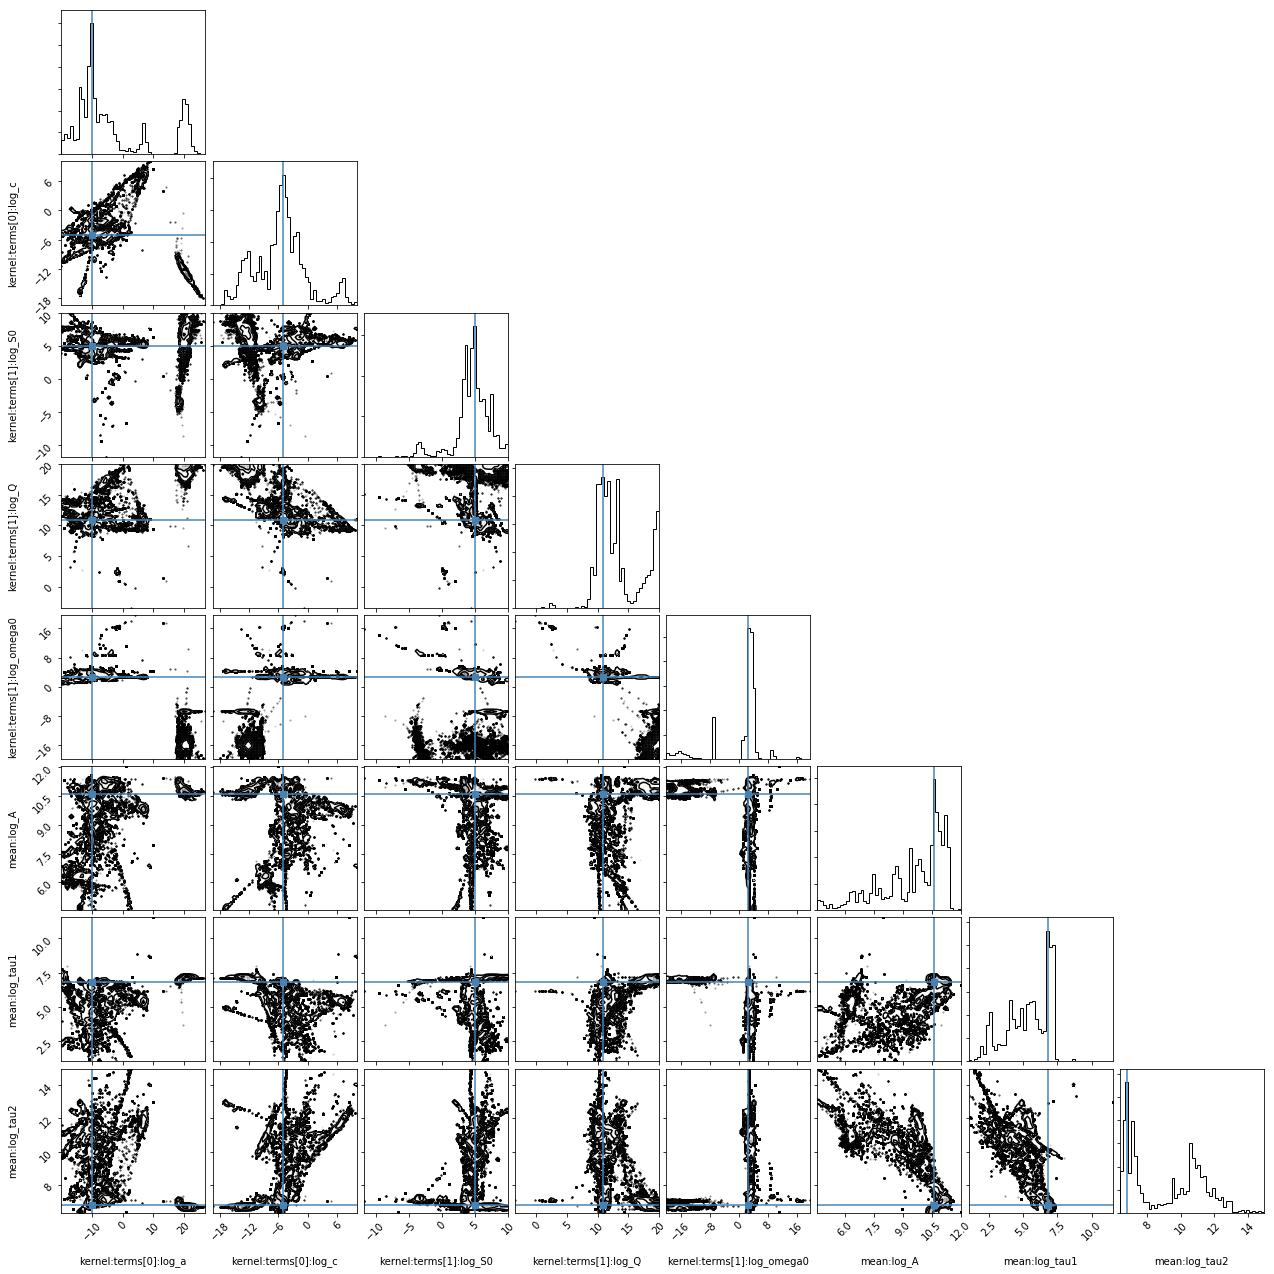

In [25]:
trimratio = 0.5
trimchain = chain[:,int(trimratio * len(chain[0])):,:]

print("Plotting time series...")
figsam = qpp.plot_chain(chain, labels = gp.get_parameter_names())

print("Plotting posterior predictions...")
figoptsam = qpp.plot_gp(tt, ft, ft_err, gp, model, chain=chain)

print("Plotting corner plot...")
figcorner, maxparams = qpp.plot_corner(chain, labels = gp.get_parameter_names())
print "Max logparams:"
print maxparams
print "Max params:"
print np.e**maxparams
plt.show()

In [26]:
fname = "burst_" + str(burstid) + ".hdf5"
f = h5py.File(fname, "w")
chain_dset = f.create_dataset("chain", chain.shape, chain.dtype)


In [23]:
#%load_ext autoreload
%autoreload
import QPP_Funcs as qpp